In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf

2023-12-20 23:38:09.689878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 23:38:09.689917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 23:38:09.691205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 23:38:09.699841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 23:38:10.846749: W tensorflow/compiler/tf2

In [2]:
# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

# A partir de aquí, puedes continuar con la construcción y entrenamiento de tu modelo de Keras

In [3]:
def generatePlot(history):
    # Extracción de datos
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Carga de las muestras de los animales

In [4]:
from keras.preprocessing.image import ImageDataGenerator
import os

image_size = 224
batch_size = 16
rescale_factor = 1./255

# Directorio conjunto entrenamiento
data_dir='./Data/animals/Train/'


# Crear un generador para aumentar datos
train_datagen = ImageDataGenerator(
    rescale=rescale_factor,    # Normalizar los valores de los píxeles
    shear_range=0.2,   # Rango para las transformaciones aleatorias
    zoom_range=0.2,    # Rango para el zoom aleatorio
    horizontal_flip=True, # Activar el giro horizontal aleatorio
    validation_split=0.2) # Establecer el porcentaje de imágenes para el conjunto de validación

# Cargar imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    data_dir,      # Directorio con datos
    target_size=(image_size, image_size), # Cambiar el tamaño de las imágenes a 50x50
    batch_size=batch_size,
    class_mode='categorical', # 'binary' para clasificación binaria, 'categorical' para multiclase
    subset='training') # Seleccionar solo el conjunto de entrenamiento

# Cargar imágenes de validación
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # Seleccionar solo el conjunto de validación

Found 8550 images belonging to 6 classes.
Found 2134 images belonging to 6 classes.


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Crear un modelo secuencial
model = Sequential()

# Agregar el modelo VGG16 al modelo secuencial
model.add(base_model)


model.add(Flatten())


model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5 ))


model.add(Dense(6, activation='softmax'))  # Usar 'softmax' para clasificación multi-clase

# Congelar las capas del modelo VGG16 preentrenado
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
print(model.summary())

2023-12-20 23:38:12.428306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 23:38:12.455300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 23:38:12.455544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 27563334 (105.15 MB)
Trainable params: 12848646 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
None


In [6]:
from keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15)  # 'patience' es el número de épocas sin mejora después de las cuales el entrenamiento se detendrá

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 100

# Entrenar el modelo con Early Stopping
history_of_train = model.fit_generator(
        train_generator,
        epochs=epochs,
        validation_data = validation_generator,
        callbacks = [early_stopping],
        steps_per_epoch=250
)

/tmp/ipykernel_8981/1201683323.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_of_train = model.fit_generator(


Epoch 1/100


2023-12-20 23:38:14.256775: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-20 23:38:20.244170: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efb5d158ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 23:38:20.244191: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-12-20 23:38:20.249722: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703115500.319440    9103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 61s 216ms/step - loss: 1.3731 - accuracy: 0.6060 - val_loss: 0.6734 - val_accuracy: 0.7498
Epoch 2/100
250/250 [==============================] - 52s 208ms/step - loss: 0.7904 - accuracy: 0.6927 - val_loss: 0.5203 - val_accuracy: 0.8187
Epoch 3/100
250/250 [==============================] - 51s 204ms/step - loss: 0.7140 - accuracy: 0.7200 - val_loss: 0.5966 - val_accuracy: 0.7737
Epoch 4/100
250/250 [==============================] - 52s 206ms/step - loss: 0.6596 - accuracy: 0.7569 - val_loss: 0.4798 - val_accuracy: 0.8233
Epoch 5/100
250/250 [==============================] - 51s 203ms/step - loss: 0.6488 - accuracy: 0.7519 - val_loss: 0.4566 - val_accuracy: 0.8243
Epoch 6/100
250/250 [==============================] - 62s 246ms/step - loss: 0.6091 - accuracy: 0.7674 - val_loss: 0.5406 - val_accuracy: 0.7919
Epoch 7/100
250/250 [==============================] - 84s 338ms/step - loss: 0.5858 - accuracy: 0.7760 - val_loss: 0.4424 - val_accurac

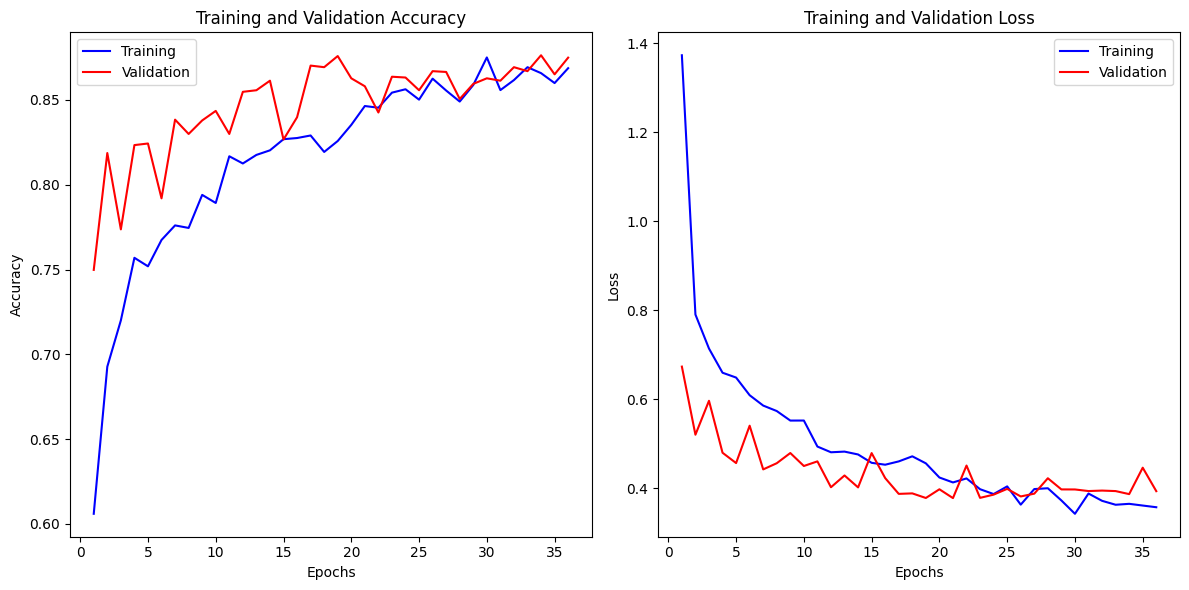

In [8]:
generatePlot(history_of_train)